# Instacart Data Mining and Visualization Homework

In this project. We're gonna explore a supermarket dataset. The dataset is from *Instacart*. We're going to see if we can find some interessing behaviors of customers and how we can exploit the results to improve a supermarket business.

## Task 0 : Warm up

Importing necessary modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

Importing data into a dataframe

In [2]:
order_products_df = pd.read_csv("data/order_products__train.csv")

Showing the top rows of the data

In [3]:
order_products_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


We see that each row represents a product purchased and included in an order.

Loading the equivalence id <=> product

In [3]:
mapFile = "data/products.csv"
with open(mapFile, encoding="utf8") as f:
    mapData = f.readlines()

idToProduct = {}

for line in mapData[1:]:
    assoc = line.split(',', 2)
    idToProduct[int(assoc[0])] = assoc[1].strip()

Number of different orders :

In [16]:
order_products_df['order_id'].nunique()

131209

Number of different products :

In [17]:
order_products_df['product_id'].nunique()

39123

Newly ordered and reordered products count :

In [20]:
order_products_df.groupby('reordered')['order_id'].count()

reordered
0    555793
1    828824
Name: order_id, dtype: int64

### Statistics on number of products per order

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]), <a list of 75 Text xticklabel objects>)

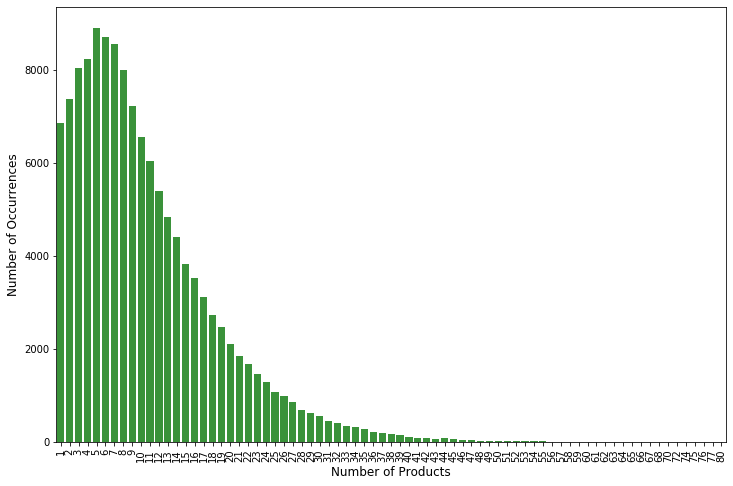

In [21]:
products_count = order_products_df.groupby('order_id')['product_id'].count().reset_index()
products_count = products_count.product_id.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(products_count.index, products_count.values, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Products', fontsize=12)
plt.xticks(rotation='vertical')

We see that generally, people buy roughly **5** products per visit.

Maximum, minimum and average number of bought products per visit in out dataset :

In [75]:
max = order_products_df.groupby('order_id')['product_id'].count().max()
min = order_products_df.groupby('order_id')['product_id'].count().min()
mean = order_products_df.groupby('order_id')['product_id'].count().mean()

print ('Maximum : %d' % (max))
print ('Minimum : %d' % (min))
print ('Average : %d' % (mean))

Maximum : 80
Minimum : 1
Average : 10


## Task 1 : Frequent Itemset Mining

### Apriori Implementation

In [46]:
from collections import Counter

def apriori(data, minSup):
    print("The dataset has:",len(data),"transactions")
    print("Mining with minimum support:",minSup,"(",100*minSup/len(data),"%)")
    # Compute support of 1-itemsets
    flatten_db = [item for transaction in data for item in transaction]
    C1 = Counter(flatten_db)
    
    # Remove infrequent 1-itemsets
    L1 = []
    supportList = []
    for item, support in C1.items():
        if support >= minSup:
            L1.append([item])
            supportList.append(support)
            
    results = [L1]
    k = 1
    while len(results)>=k and k<6: # The k<6 prevents Apriori to look for itemsets of more than 5 elements
        # Generate
        Ckp1 = apriori_gen(results[k-1],k)
        
        # Test
        Ckp1_count = [0] * len(Ckp1)
        #  - Scan data, counting one per transaction containing itemset
        for transaction in data:
            st = set(transaction)
            for i, itemset in enumerate(Ckp1):
                si = set(itemset)
                if si.issubset(st): 
                    Ckp1_count[i] += 1
        #   - Record itemsets that have a high enough frequency
        Lkp1 = []
        for i, itemset in enumerate(Ckp1):
            if Ckp1_count[i] >= minSup:
                #print(itemset,"is frequent (support=",Ckp1_count[i],")")
                Lkp1.append(itemset)
                supportList.append(Ckp1_count[i])
        # If any itemset stored in Lk+1, add it to the final result (will allow general loop to continue)
        if Lkp1:
            results.append(Lkp1)
        
        k = k+1
    
    # Return temporary result
    return results, supportList

from itertools import combinations

def apriori_gen(Lk, k):
    #print("Apriori_gen",Lk)
    # Sort elements of Lk based on itemset prefixes (lexicographic sort)
    sortedLk = list(Lk) 
    sortedLk.sort() # don't care about support here. Python sort of list is lexicographic
    # Create Ckp1 by joining elements of Lk having same k-1 prefix
    Ckp1 = []
    for itemset1, itemset2 in combinations(sortedLk,2):           
        if itemset1[:-1] == itemset2[:-1]:
            Ckp1.append(itemset1 + [itemset2[-1]])
    # Prune elements of Ckp1 having subsets not in Lk
    result = []
    for itemset in Ckp1:
        subsets = combinations(itemset, len(itemset)-1)
        keep = True
        for s in subsets:
            s = list(s)
            if s not in Lk: 
                keep = False
                # print("subset",s,"of",itemset,"is not in L",k,"-> pruning")
                break;
        if keep:
            result.append(itemset)
            # print(itemset,"added to C",k+1)
    return result

def prettyPrintFIS(fisList, supportList):
    i = 0
    k = 1
    for Lk in fisList:
        print(k,"-itemsets")
        for itemset in Lk:
            print([idToProduct[id] for id in itemset]," : ", supportList[i])
            i += 1
        k += 1
    print("TOTAL: ",i+1,"itemsets")

### Question 1.1

To be able to mine frequent itemsets, we need to transform the data into a  format exploitable by the Apriori algorithm. That is, the data needs to be in the form of a list of transactions. In our case, a transaction is an order, and the items are the different products.

To do that, we start by grouping our data by id. Then for each subgroup, we create an array of the different product ids. Then we append each one of these arrays to our final list.

In [79]:
dataset = order_products_df.groupby('order_id')['product_id'].apply(list).values
print(dataset[:5])

[list([49302, 11109, 10246, 49683, 43633, 13176, 47209, 22035])
 list([39612, 19660, 49235, 43086, 46620, 34497, 48679, 46979])
 list([11913, 18159, 4461, 21616, 23622, 32433, 28842, 42625, 39693])
 list([20574, 30391, 40706, 25610, 27966, 24489, 39275])
 list([8859, 19731, 43654, 13176, 4357, 37664, 34065, 35951, 43560, 9896, 27509, 15455, 27966, 47601, 40396, 35042, 40986, 1939, 46313, 329, 30776, 36695, 27683, 15995, 27344, 47333, 48287, 45204, 24964, 18117, 46413, 34126, 9373, 22935, 46720, 44479, 790, 18441, 45007, 20520, 7461, 26317, 3880, 36364, 32463, 41387, 31066, 17747, 25659])]


### Question 1.2

The maximal support is the total number of occurences of the most frequent product. Let find out for each product how many times it appears and sort the results by descending order :

In [80]:
order_products_df.groupby('product_id')['order_id'].count().reset_index(name='count').sort_values(['count'], ascending=False).head()

,product_id,count
19574,24852,18726
10367,13176,15480
16685,21137,10894
17300,21903,9784
37499,47626,8135


As we can see, the most frequent product appears **18726** times, that is our max support.

### Question 1.3

Let's run *Apriori* on our preprocessed dataset :

In [49]:
import time
start_time = time.time()
FIS, support = apriori(dataset, 900)
aprioriTime = time.time() - start_time
print("Execution time : %s seconds" % aprioriTime)

The dataset has: 131209 transactions
Mining with minimum support: 900 ( 0.6859285567301023 %)
Execution time : 552.5162303447723 seconds


In [50]:
prettyPrintFIS(FIS, support)

1 -itemsets
[10246]  :  1062
[49683]  :  2413
[13176]  :  15480
[47209]  :  7293
[22035]  :  1993
[19660]  :  2225
[49235]  :  2646
[48679]  :  2568
[46979]  :  3868
[21616]  :  2923
[28842]  :  1920
[30391]  :  4613
[40706]  :  3823
[27966]  :  5546
[24489]  :  1213
[39275]  :  4966
[8859]  :  950
[35951]  :  2176
[36695]  :  926
[27344]  :  1788
[24964]  :  4158
[34126]  :  2400
[22935]  :  4290
[45007]  :  4589
[25659]  :  1045
[27104]  :  2651
[5876]  :  3505
[5077]  :  2298
[43772]  :  1024
[21137]  :  10894
[17794]  :  2497
[11182]  :  1147
[28199]  :  1478
[24852]  :  18726
[1940]  :  931
[33000]  :  1476
[11520]  :  1898
[6184]  :  1351
[12341]  :  2276
[16797]  :  6494
[14992]  :  1160
[31506]  :  2068
[47626]  :  8135
[47144]  :  1465
[42265]  :  3597
[31717]  :  3526
[34358]  :  1920
[8424]  :  2932
[21405]  :  1041
[41220]  :  1154
[9387]  :  1379
[45066]  :  3551
[21903]  :  9784
[9076]  :  2323
[10749]  :  2393
[16759]  :  1742
[8193]  :  1418
[43789]  :  1222
[26209]  : 

### Question 1.4

Transforming the data to the expected format and saving it to a file :

In [63]:
sorted_dataset = dataset
for transaction in dataset: transaction.sort()
    
f= open("data/LCM_input.txt","w+")

for transaction in sorted_dataset:
    line = " ".join(str(x) for x in transaction)
    f.write(line+'\n')
    
f.close()

Running the algorithm. The results are saved to *LCM_output.txt*.

In [119]:
import os

import time
start_time = time.time()
os.system('java -jar spmf.jar run LCM data/LCM_input.txt data/LCM_output.txt 0.4%')
LCMTime = time.time() - start_time
print("Execution time : %s seconds" % LCMTime)

Execution time : 6.10992431640625 seconds


Converting ids to their corresponding string for a better understanding of our results :

In [114]:
def convertPatternFile(patternsFile, outputFile):
    with open(patternsFile) as p, open(outputFile, 'w') as o:
        pattData = p.readlines()
        pattDict = {}
        numPattDict = {}
        
        for pattLine in pattData:
            supportSplit = pattLine.split("#", 1)
            items = supportSplit[0].strip().split(' ')
            decodedPattern = idToProduct[int(items[0])]
            for item in items[1:]:
                decodedPattern += " // " + idToProduct[int(item)] 

            support = int(supportSplit[1].split(':')[1].strip())
            pattDict[decodedPattern] = support
            numPattDict[decodedPattern] = items

        pattDict_sorted_keys = sorted(pattDict, key=pattDict.get, reverse=True)
        for k in pattDict_sorted_keys:
            o.write(k + " ### support: " + str(pattDict[k]) + "  ### [" + ', '.join(numPattDict[k]) + "]" +  "\n")


In [120]:
convertPatternFile("data/LCM_output.txt", "data/LCM_output_converted.txt")

Exemples of what the final output looks like :
- Banana ### support: 18726  ### [24852]
- Bag of Organic Bananas // Organic Strawberries ### support: 3074  ### [13176, 21137]
- Bag of Organic Bananas // Organic Strawberries // Organic Hass Avocado ### support: 710  ### [13176, 21137, 47209]

#### Comparing Apriori and LCM

Comparing execution time :

In [ ]:
time_diff = aprioriTime - LCMTime

We can observe that *LCM* is much faster that *Apriori* even when the minsup given to *LCM* is lower that the one given to *Apriori*. As a consequence, *LCM* outputs more frequent itemsets than *Apriori* for a significantly lower execution time (533 frequent itemsets for *LCM* against 215 for *Apriori*).

### Question 1.5

We want to create a graph that would help us determine what aisles shoud be placed far apart. We start by creating an dictionnary of pairs of frequent aisles for which products appear together in our closed frequent itemsets together with there counts. We only use 2-itemsets for simplicity.

The following methods allow us to respectively convert a product's ID to the corresponding aisle's ID and an ailse's ID to the corresponding aisle's name.

In [60]:
def productToAisle(id):
    products = pd.read_csv('data/products.csv', index_col='product_id')    
    return int(products.at[id, 'aisle_id'])

def idToAisle(id):
    aisles = pd.read_csv('data/aisles.csv', index_col='aisle_id')
    return aisles.at[id, 'aisle']
    

Next, we generate the pairs :

In [85]:
import re

aislePairs = {}

with open("data/LCM_output.txt") as f:
    data = f.readlines()
    
    for line in data:
        m = re.match(r'^(\d*)\s(\d*)\s#SUP:\s\d*', line)
        if (m != None):
            pair = [productToAisle(int(m.group(1))), productToAisle(int(m.group(2)))]
            if (pair[0] != pair[1]):
                pair.sort()
                pair = (idToAisle(pair[0]), idToAisle(pair[1]))
                if pair in aislePairs:
                    aislePairs[pair] += 1
                else:
                    aislePairs[pair] = 1

        

First 10 elements of our generated pairs looks like this :

In [82]:
dict(list(aislePairs.items())[0:10])

{('fresh vegetables', 'packaged vegetables fruits'): 10,
 ('fresh fruits', 'fresh vegetables'): 58,
 ('fresh fruits', 'packaged vegetables fruits'): 33,
 ('fresh fruits', 'bread'): 1,
 ('fresh herbs', 'fresh vegetables'): 1,
 ('fresh fruits', 'frozen produce'): 1,
 ('fresh fruits', 'packaged produce'): 5,
 ('packaged cheese', 'fresh fruits'): 1,
 ('fresh fruits', 'milk'): 3,
 ('fresh fruits', 'fresh dips tapenades'): 2}

We convert out dictionnary to an array :

In [ ]:
aislePairsArray = [[k[0], k[1], v] for k,v in dict(list(aislePairs.items())).items()]

Now we can build our graph.

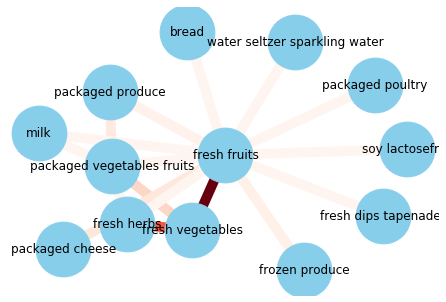

In [133]:
import networkx as nx

df = pd.DataFrame(aislePairsArray, columns=['from', 'to', 'value'])

G=nx.from_pandas_edgelist(df, 'from', 'to')

nx.draw(G, with_labels=True, node_color='skyblue', node_size=3000, edge_color=df['value'], width=10.0, edge_cmap=plt.cm.Reds)

The nodes represent the different aisles and the edges represent products of the corresponding aisles that are bought together. The more an edge is dark, the more products from those aisles are bought together. We can see that **fresh fruits** and **fresh vegetables** are often bought together. Same goes for **fresh vegetables** and **fresh herbs**. One could think that placing those aisles far from each others could benefit the supermarket. Globally, this graph gives us insights on which aisles should be placed far from each other.

### Question 1.6

We're gonna use the *Mlxtend* library to compute association rules.

In [4]:
from mlxtend.frequent_patterns import association_rules

Preparing the data :

In [12]:
def dataToMlxtendFormat(patternsFile, totalTransactions):
    with open(patternsFile) as p:
        data = p.readlines()
        
        result = []
        
        for line in data:
            row = []
            split1 = line.split(' ### ')
            support = int(split1[1].split(' ')[1])/totalTransactions
            row.append(support)
            split2 = split1[0].split(' // ')
            row.append(tuple(split2))            
            result.append(row)
            
        return pd.DataFrame(result, columns=['support', 'itemsets'])

In [22]:
freq_items = dataToMlxtendFormat('data/LCM_output_converted.txt', order_products_df.size)
freq_items

,support,itemsets
0,0.003381,"(Banana,)"
1,0.002795,"(Bag of Organic Bananas,)"
2,0.001967,"(Organic Strawberries,)"
3,0.001767,"(Organic Baby Spinach,)"
4,0.001469,"(Large Lemon,)"
...,...,...
528,0.000095,"(Carrots, Banana)"
529,0.000095,"(Organic Free Range Chicken Broth,)"
530,0.000095,"(Broccoli Crown, Large Lemon)"
531,0.000095,"(Organic Broccoli, Bag of Organic Bananas)"


Computing the association rules :

In [27]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Organic Strawberries),(Bag of Organic Bananas),0.001967,0.002795,0.000555,0.282174,100.956709,0.000550,1.389201
1,(Organic Hass Avocado),(Bag of Organic Bananas),0.001317,0.002795,0.000437,0.331825,118.721082,0.000433,1.492431
2,(Organic Baby Spinach),(Bag of Organic Bananas),0.001767,0.002795,0.000404,0.228536,81.766244,0.000399,1.292614
3,(Organic Avocado),(Banana),0.001338,0.003381,0.000400,0.299096,88.461601,0.000396,1.421904
4,(Large Lemon),(Banana),0.001469,0.003381,0.000390,0.265274,78.458232,0.000385,1.356449
...,...,...,...,...,...,...,...,...,...
91,"(Organic Hass Avocado, Organic Raspberries)",(Bag of Organic Bananas),0.000184,0.002795,0.000096,0.521099,186.439973,0.000095,2.082278
92,"(Organic Hass Avocado, Bag of Organic Bananas)",(Organic Raspberries),0.000437,0.001001,0.000096,0.219421,219.123492,0.000095,1.279818
93,"(Organic Raspberries, Bag of Organic Bananas)",(Organic Hass Avocado),0.000321,0.001317,0.000096,0.298315,226.546812,0.000095,1.423264
94,(Carrots),(Banana),0.000451,0.003381,0.000095,0.211053,62.421860,0.000094,1.263227


#### Post-processing and filtering the generated rules

This method allows us to select rules concluding on a single
determined product :

In [51]:
def singleProduct(df, product):
    for index, row in df.iterrows():
        if row['consequents'] == frozenset([product]):
            support = str(int(row['support'])*order_products_df.size)
            confidence = str(row['confidence'])
            print(' , '.join(row['antecedents'])+' -> '+product+' ### Support : '+support+' ### Confidence : '+confidence)
    
    

An exemple of rules concluding to *\"Organic Raspberries\"* :

In [54]:
singleProduct(rules, 'Organic Raspberries')

Organic Strawberries , Bag of Organic Bananas -> Organic Raspberries ### Support : 0 ### Confidence : 0.21112556929082632
Organic Hass Avocado , Bag of Organic Bananas -> Organic Raspberries ### Support : 0 ### Confidence : 0.2194214876033058


This method allows us to select rules concluding only on products from a specific aisle :

In [63]:
def specificAisle(df, aisle):
    for index, row in df.iterrows():
        def inner() :
            for p in row['consequents']:
                productId =  list(idToProduct.keys())[list(idToProduct.values()).index(p)]
                aisleId = productToAisle(productId)
                current_aisle = idToAisle(aisleId)
                if current_aisle != aisle: return
            support = str(int(row['support'])*order_products_df.size)
            confidence = str(row['confidence'])
            print(' , '.join(row['antecedents'])+' -> '+''.join(row['consequents'])+' ### Support : '+support+' ### Confidence : '+confidence)
        inner()

An exemple of rules concluding to products from the *\"packaged vegetables fruits\"* aisle :

In [68]:
specificAisle(rules, 'packaged vegetables fruits')

Organic Zucchini -> Organic Baby Spinach ### Support : 0 ### Confidence : 0.2070167792547396
Organic Cucumber -> Organic Baby Spinach ### Support : 0 ### Confidence : 0.2022544981573813
Organic Grape Tomatoes -> Organic Baby Spinach ### Support : 0 ### Confidence : 0.22181532827622283
Organic Strawberries , Bag of Organic Bananas -> Organic Raspberries ### Support : 0 ### Confidence : 0.21112556929082632
Organic Garnet Sweet Potato (Yam) -> Organic Baby Spinach ### Support : 0 ### Confidence : 0.24026479750778817
Michigan Organic Kale -> Organic Baby Spinach ### Support : 0 ### Confidence : 0.20251237152645601
Organic Hass Avocado , Bag of Organic Bananas -> Organic Raspberries ### Support : 0 ### Confidence : 0.2194214876033058


Some interesting rules that I've able to extract :
- *Organic Strawberries , Bag of Organic Bananas -> Organic Raspberries :*
   - This suggest that the user might want to make a smoothie 🥤
- *Organic Grape Tomatoes -> Organic Baby Spinach :*
    - This suggest that the user might want to make a salad 🥗

## Task 2 : Sequential Pattern Mining

### Question 2.1

We are now going to consider one transaction for each user where the sequence of orders represents the transaction. The items will be the products.

Transforming the data into the expected format

In [131]:
sequences = pd.read_csv('data/transactions_seq.txt', sep="	", header=None, names=['user id', 'order number', 'size of order', 'products'], encoding='latin-1')
sequences.head()

,user id,order number,size of order,products
0,1,1,5,"AgedWhiteCheddarPopcorn,OrganicUnsweetenedVani..."
1,1,2,6,"AgedWhiteCheddarPopcorn,BagofOrganicBananas,Ci..."
2,1,3,5,"CreamyAlmondButter,OrganicStringCheese,Origina..."
3,1,4,5,"OrganicStringCheese,OriginalBeefJerky,Pistachi..."
4,1,5,8,"BagofOrganicBananas,BartlettPears,HoneycrispAp..."


In [4]:
def convertSequenceFile(sequenceFile, outputFile):
    with open(outputFile, 'w') as o:
        sequences = pd.read_csv(sequenceFile, sep="	", header=None, names=['user id', 'order number', 'size of order', 'products'], encoding='latin-1')
        
        grouped = sequences.groupby('user id')
        
        productToId = dict((v.replace(' ', ''),k) for k,v in idToProduct.items())

        for name, group in grouped:
            line = ''
            for row_index, row in group.iterrows():
                products = row['products'].split(',')
                products_str = ''
                ids = []
                for product in products:
                    ids.append(productToId[product])
                ids.sort()
                for id in ids:
                    products_str = products_str + str(id) + ' ' 
                line = line + products_str + '-1 '
            line = line + '-2\n'
            
            o.write(line)

In [5]:
convertSequenceFile('data/transactions_seq.txt', 'data/CloSpan_input.txt')

KeyError: 'BakedRiceandCornPuffs'

#### ⚠ Encountered problem

When trying to process the data. I came across a problem.
The provided file contains a list of products for each order. This list is in the form of coma separated products. However, some of the indivual products are in the form of coma separated "items". For exemple, in the *products.csv* file, I found a product named : *Baked Rice and Corn Puffs, Aged White Cheddar*. This product appears in one of the transactions aswell (the 11th to be precise). We end up with a product list looking like this :

> BakedRiceandCornPuffs,AgedWhiteCheddar,Eggs,Hard-Boiled,HardBoiledEggs,...

Now if we want to split this list using comas as seperators, we will end up with 2 different products *BakedRiceandCornPuffs* and *AgedWhiteCheddar* while they appear as a single product in the original database.

For this reason, after writing the solution code that I think would have worked if I didn't encounter this problem, I haven't been able to complete this task.

In [ ]:
import os
os.system('java -jar spmf.jar run CloSpan data/CloSpan_input.txt data/CloSpan_output.txt 50%')

### Question 2.2

> ⚠ Imcomplete because of the problem explained above.